In [144]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import plotly.graph_objects as go
from plotly.offline import iplot


In [159]:
df_up = pd.read_csv('../input/the-bread-basket/bread basket.csv')

# Data Exploration


In [146]:
print('dimensions:', df_up.shape)
df_up['date_time']= pd.to_datetime(df_up['date_time'])

# Extract hour, day of week, date and month
df_up['hour'] = df_up['date_time'].dt.hour
df_up['day_of_week'] = df_up['date_time'].dt.day_name()
df_up['day'] = df_up['date_time'].dt.day
df_up['month'] = df_up['date_time'].dt.month

dimensions: (20507, 5)


In [65]:
#check for null values
tab_info=pd.DataFrame(df_up.dtypes).T.rename(index={0:'column type'})
tab_info=pd.concat([tab_info,pd.DataFrame(df_up.isnull().sum()).T.rename(index={0:'null values (nb)'})])
tab_info=pd.concat([tab_info,pd.DataFrame(df_up.isnull().sum()/df_up.shape[0]*100).T.
                         rename(index={0:'null values (%)'})])
display(tab_info)

,Transaction,Item,date_time,period_day,weekday_weekend
column type,int64,object,datetime64[ns],object,object
null values (nb),0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0


In [75]:
#check for duplicates
print('duplicates: {}'.format(df_up.duplicated().sum()))
#drop duplicates
df_up.drop_duplicates(inplace = True)

duplicates: 1620


In [76]:
pd.DataFrame([{'Items': len(df_up['Item'].value_counts()),    
               'transactions': len(df_up['Transaction'].value_counts()),
                
              }], columns = ['Items', 'transactions'], index = ['quantity'])

,Items,transactions
quantity,94,9465


94 different items have been bought in 9465 different transactions.

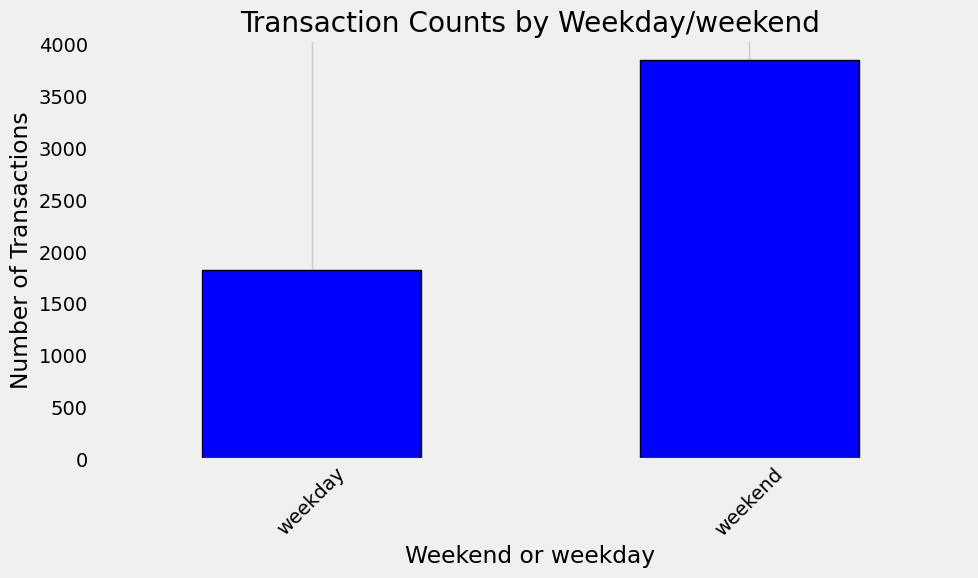

In [152]:
period_counts = df_up.groupby('weekday_weekend').size()

period_counts['weekday']=period_counts['weekday']/7
period_counts['weekend']=period_counts['weekend']/2
# Plot the average number of transactions during weekday and weekend
plt.figure(figsize=(10, 6))
period_counts.plot(kind='bar', color='b', edgecolor='black')
plt.title('Transaction Counts by Weekday/weekend')
plt.xlabel('Weekend or weekday')
plt.ylabel('Number of Transactions')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


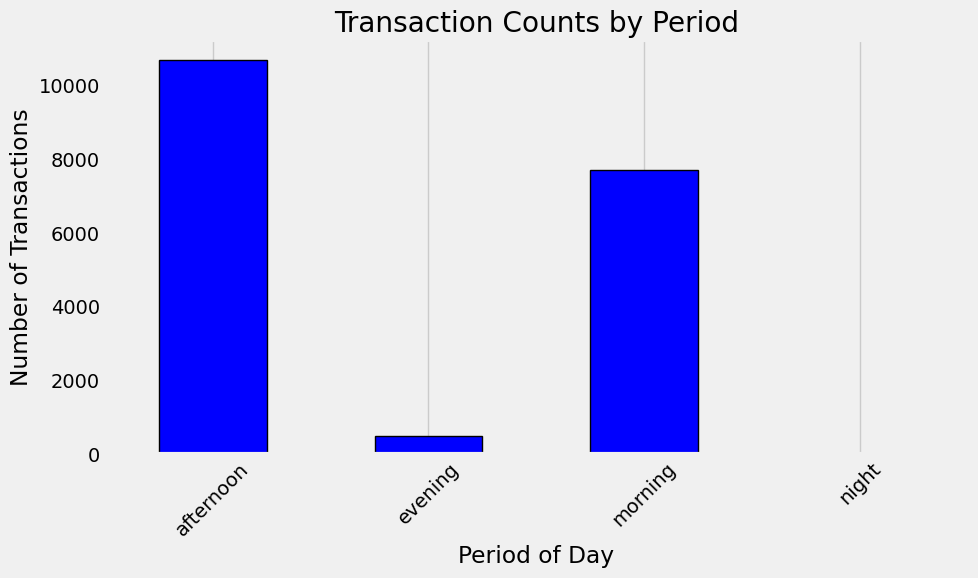

In [77]:
period_counts = df_up.groupby('period_day').size()

# Plot the transaction counts by period
plt.figure(figsize=(10, 6))
period_counts.plot(kind='bar', color='b', edgecolor='black')
plt.title('Transaction Counts by Period')
plt.xlabel('Period of Day')
plt.ylabel('Number of Transactions')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


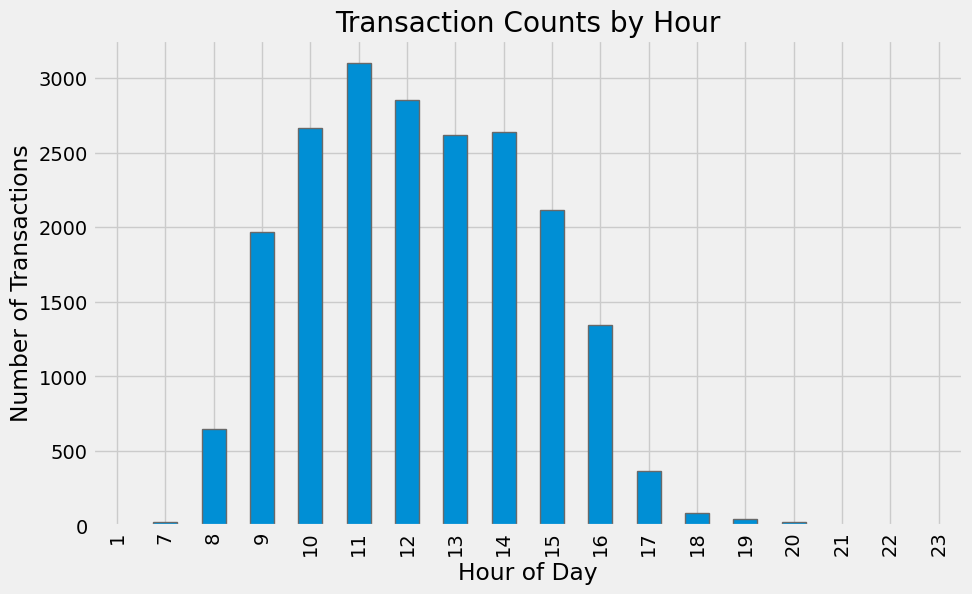

In [8]:

hourly_counts = df_up.groupby('hour').size()

# Plot transactions by hours
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
hourly_counts.plot(kind='bar')
plt.title('Transaction Counts by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()


Sales are very low at night time but are at a peak from 10:00 am to 3:00 pm 

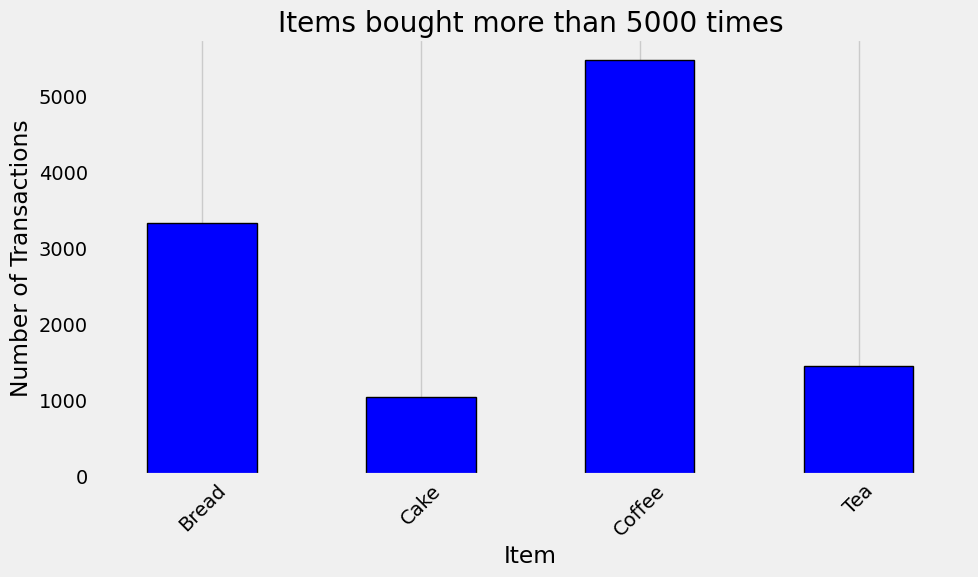

In [162]:
item_counts = df_up.groupby('Item').size()
item_counts= item_counts[item_counts>=1000]

# Plot the transaction counts by period
plt.figure(figsize=(10, 6))
item_counts.plot(kind='bar', color='b', edgecolor='black')
plt.title('Items bought more than 5000 times')
plt.xlabel('Item')
plt.ylabel('Number of Transactions')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

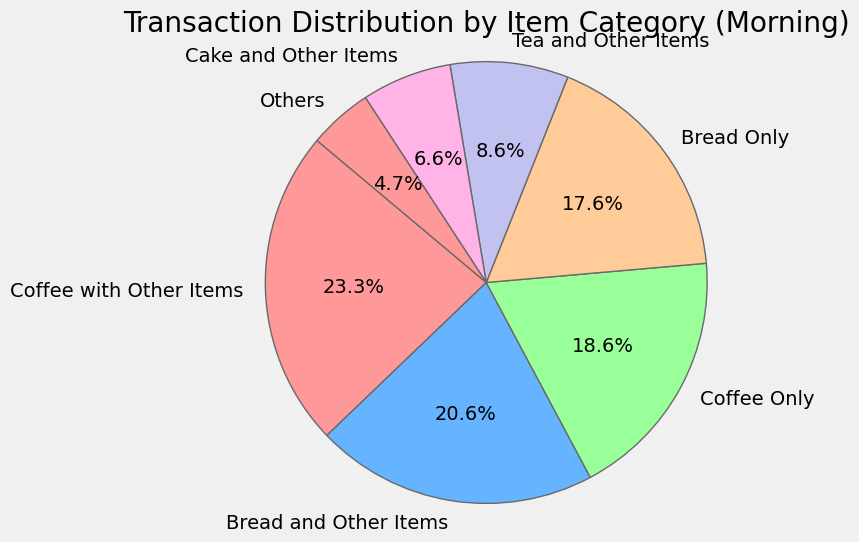

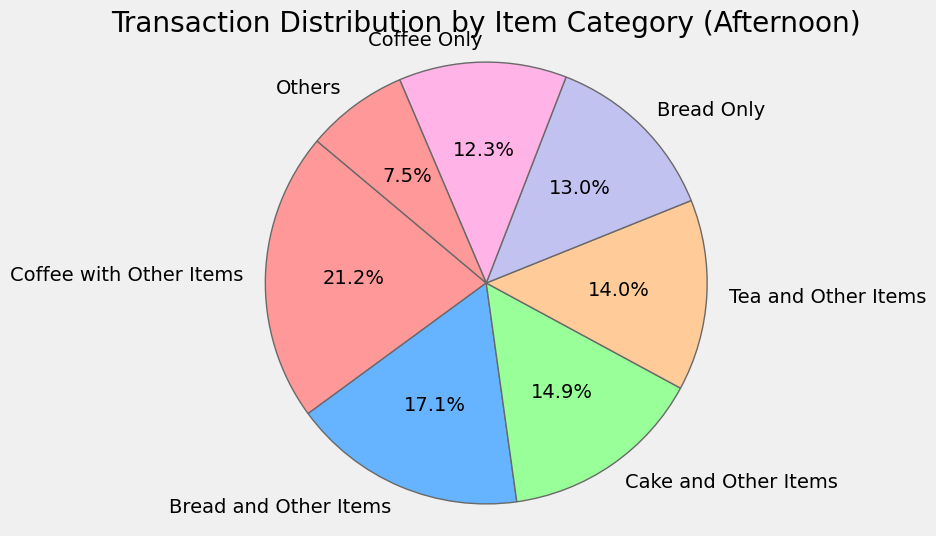

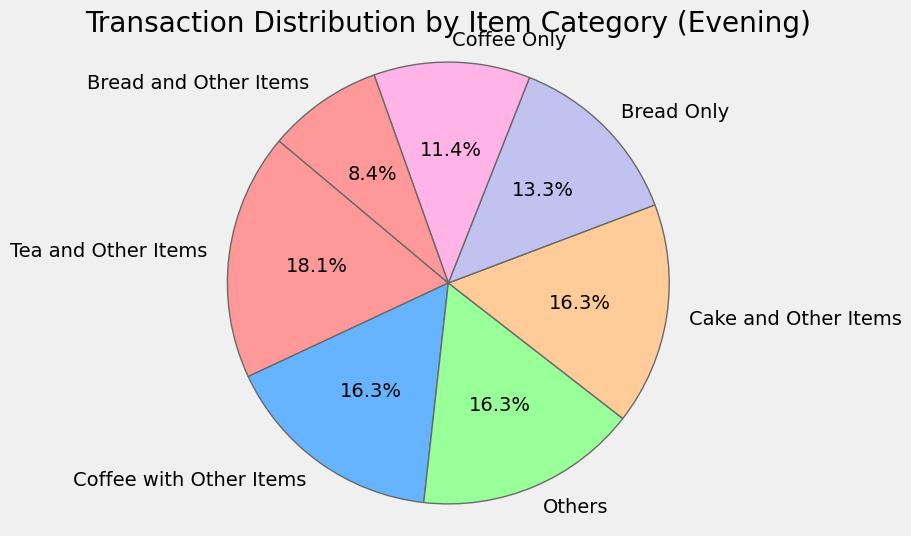

In [142]:

# Define periods of the day
periods = ['morning', 'afternoon', 'evening']

# Categorize transactions
def categorize(item_str):
    items = set(item_str.split(','))
    if len(items) == 1:
        item = items.pop()
        if item == 'Bread':
            return 'Bread Only'
        
        elif item == 'Coffee':
            return 'Coffee Only'
    elif 'Cake' in items:
        return 'Cake and Other Items'
    elif 'Tea' in items:
        return 'Tea and Other Items'
    elif 'Bread' in items:
        return 'Bread and Other Items'
    elif 'Coffee' in items:
        return 'Coffee with Other Items'
    else:
        return 'Others'

# Iterate through each period and generate pie charts
for period in periods:
    period_df = df_up[df_up['period_day'] == period]
    
    transaction_items = period_df.groupby('Transaction')['Item'].apply(lambda x: ','.join(sorted(x))).reset_index()

    # Apply categorization
    transaction_items['Category'] = transaction_items['Item'].apply(categorize)
    category_counts = transaction_items['Category'].value_counts()
    labels = category_counts.index
    sizes = category_counts.values
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']

    # Plotthe pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(f'Transaction Distribution by Item Category ({period.capitalize()})')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


Coffee is the best selling item in this bakery 

Apriori algorithm -> All subsets of a frequent itemset must be frequent(Apriori property).
If an itemset is infrequent, all its supersets will be infrequent.

# Association rules

**Support**

![image.png](https://images.datacamp.com/image/upload/v1674491861/Support_Formula_e4d9c995bb.png)

**Confidence**

![image.png](https://images.datacamp.com/image/upload/v1674491862/Confidence_Formula_eade731502.png)

**Lift**

![image.png](https://images.datacamp.com/image/upload/v1674491862/Lift_Formula_0c1b28e4d5.png)

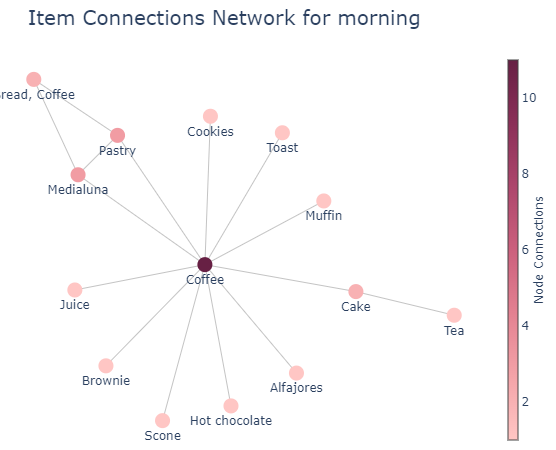

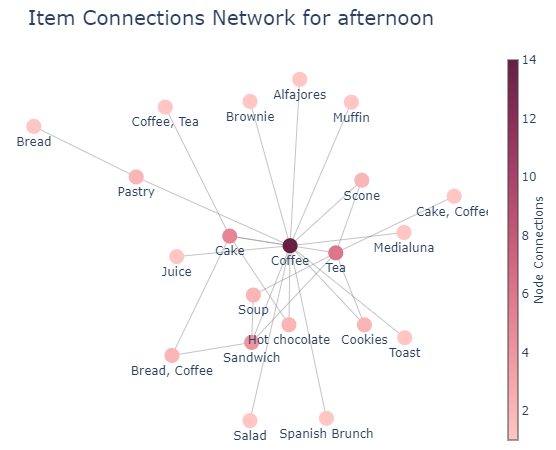

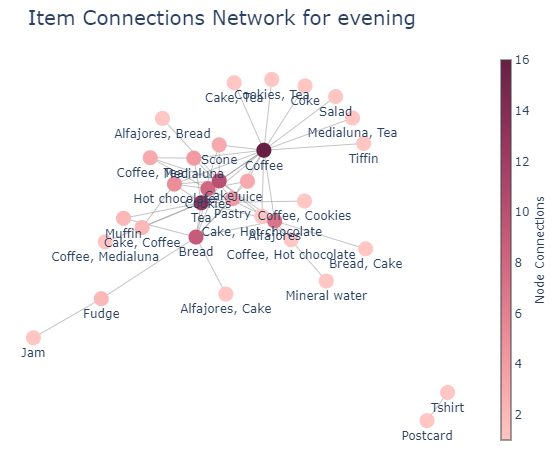

In [167]:
# Define periods of the day
periods = ['morning', 'afternoon', 'evening']

def frozenset_to_str(frozenset_obj):
    if isinstance(frozenset_obj, frozenset):
        return ', '.join(sorted(frozenset_obj))
    return str(frozenset_obj)

def generate_rules(period):
    # Filter data for the specific period
    period_df = df_up[df_up['period_day'] == period]
    
    # Create basket dataframe
    basket_df = period_df.groupby(['Transaction', 'Item'])['Item'].count().unstack().reset_index().fillna(0).set_index('Transaction')
    basket_df = basket_df.applymap(lambda x: x > 0)  # Convert to boolean

    # Generate frequent itemsets and rules
    item_freq = basket_df.sum()
    min_support = 0.01
    frequent_items = item_freq[item_freq / len(basket_df) >= min_support].index
    filtered_basket_df = basket_df[frequent_items]

    frequent_itemsets = apriori(filtered_basket_df, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    rules.sort_values('confidence', ascending=False)
    
    # Generate and plot network graph using plotly
    network_A = list(rules["antecedents"].unique())
    network_B = list(rules["consequents"].unique())
    node_list = list(set(network_A + network_B))
    
    G = nx.Graph()
    for i in node_list:
        G.add_node(i)
    for i, j in rules.iterrows():
        G.add_edges_from([(j["antecedents"], j["consequents"])])
    
    pos = nx.spring_layout(G, k=1/np.sqrt(len(G.nodes())), iterations=20)
    for n, p in pos.items():
        G.nodes[n]['pos'] = p

    edge_trace = go.Scatter(
        x=[], y=[], 
        line=dict(width=0.5, color='#888'), 
        hoverinfo='none', mode='lines'
    )

    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])

    node_trace = go.Scatter(
        x=[], y=[], text=[], mode='markers+text', hoverinfo='none',
        textposition='bottom center',  # Position the label below the node
        marker=dict(
            showscale=True, colorscale='Burg', 
            color=[], size=15, colorbar=dict(
                thickness=10, title='Node Connections', 
                xanchor='left', titleside='right'
            )
        )
    )

    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_trace['text'] += tuple([frozenset_to_str(node)])  # Add label (item name) directly below the node

    for node, adjacencies in enumerate(G.adjacency()):
        node_trace['marker']['color'] += tuple([len(adjacencies[1])])

    fig = go.Figure(data=[edge_trace, node_trace], 
        layout=go.Layout(
            title=f'Item Connections Network for {period}', titlefont=dict(size=20),
            plot_bgcolor='white', showlegend=False, margin=dict(b=0, l=0, r=0, t=50),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
        )
    )

    iplot(fig)

# Generate rules and plots for each period
for period in periods:
    generate_rules(period)


Coffee is a popular item at all times of day except at night, and frequently paired with other items

       antecedents consequents   support  confidence      lift
30           Toast      Coffee  0.023666    0.704403  1.472431
28  Spanish Brunch      Coffee  0.010882    0.598837  1.251766
19       Medialuna      Coffee  0.035182    0.569231  1.189878
22          Pastry      Coffee  0.047544    0.552147  1.154168
0        Alfajores      Coffee  0.019651    0.540698  1.130235
16           Juice      Coffee  0.020602    0.534247  1.116750
25        Sandwich      Coffee  0.038246    0.532353  1.112792
6             Cake      Coffee  0.054728    0.526958  1.101515
26           Scone      Coffee  0.018067    0.522936  1.093107
12         Cookies      Coffee  0.028209    0.518447  1.083723


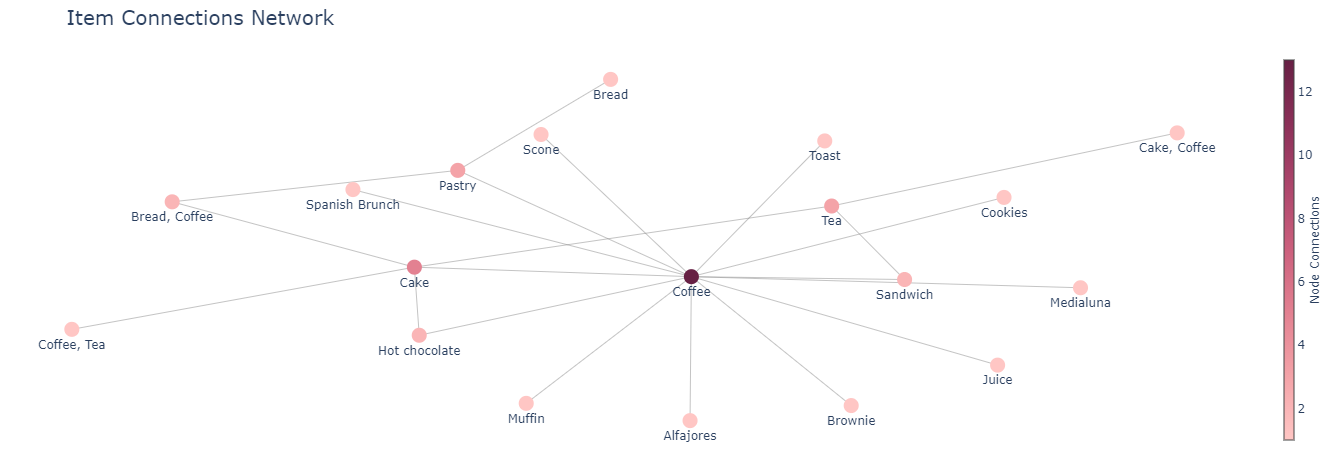

In [172]:
    # Create basket dataframe
    basket_df = df_up.groupby(['Transaction', 'Item'])['Item'].count().unstack().reset_index().fillna(0).set_index('Transaction')
    basket_df = basket_df.applymap(lambda x: x > 0)  # Convert to boolean

    # Generate frequent itemsets and rules
    item_freq = basket_df.sum()
    min_support = 0.01
    frequent_items = item_freq[item_freq / len(basket_df) >= min_support].index
    filtered_basket_df = basket_df[frequent_items]

    frequent_itemsets = apriori(filtered_basket_df, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

    rules_sorted = rules.sort_values(by='confidence', ascending=False)

    top_rules = rules_sorted.head(10)

    # Convert the frozensets of antecedents and consequents to strings for better visualization
    top_rules['antecedents'] = top_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
    top_rules['consequents'] = top_rules['consequents'].apply(lambda x: ', '.join(list(x)))

    # Select relevant columns for display
    table = top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

    print(table)
    
    # Generate and plot network graph using plotly
    network_A = list(rules["antecedents"].unique())
    network_B = list(rules["consequents"].unique())
    node_list = list(set(network_A + network_B))
    
    G = nx.Graph()
    for i in node_list:
        G.add_node(i)
    for i, j in rules.iterrows():
        G.add_edges_from([(j["antecedents"], j["consequents"])])
    
    pos = nx.spring_layout(G, k=1/np.sqrt(len(G.nodes())), iterations=20)
    for n, p in pos.items():
        G.nodes[n]['pos'] = p

    edge_trace = go.Scatter(
        x=[], y=[], 
        line=dict(width=0.5, color='#888'), 
        hoverinfo='none', mode='lines'
    )

    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])

    node_trace = go.Scatter(
        x=[], y=[], text=[], mode='markers+text', hoverinfo='none',
        textposition='bottom center',  # Position the label below the node
        marker=dict(
            showscale=True, colorscale='Burg', 
            color=[], size=15, colorbar=dict(
                thickness=10, title='Node Connections', 
                xanchor='left', titleside='right'
            )
        )
    )

    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_trace['text'] += tuple([frozenset_to_str(node)])  # Add label (item name) directly below the node

    for node, adjacencies in enumerate(G.adjacency()):
        node_trace['marker']['color'] += tuple([len(adjacencies[1])])

    fig = go.Figure(data=[edge_trace, node_trace], 
        layout=go.Layout(
            title=f'Item Connections Network', titlefont=dict(size=20),
            plot_bgcolor='white', showlegend=False, margin=dict(b=0, l=0, r=0, t=50),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
        )
    )

    iplot(fig)
